In [0]:
from IPython.display import Image
%matplotlib inline
import numpy as np

### Determining the size of the convolution output

In [2]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

In [3]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

## Putting everything together – implementing a CNN

### Working with multiple input or color channels



In [4]:
from google.colab import files
uploaded = files.upload()

Saving example-image.png to example-image.png
Saving example-image-gray.png to example-image-gray.png


In [5]:
%tensorflow_version 2.x
import tensorflow as tf


img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

TensorFlow 2.x selected.
Image shape: (252, 221, 3)
Number of channels: 3
Image data type: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [6]:
import imageio


img = imageio.imread('example-image.png')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


**INFO-BOX: The rank of a grayscale image for input to a CNN**

In [7]:
img_raw = tf.io.read_file('example-image-gray.png')
img = tf.image.decode_image(img_raw)
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

Rank: 3
Shape: TensorShape([252, 221, 1])


In [8]:
img = imageio.imread('example-image-gray.png')
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('New Shape:', img_reshaped.shape)

Rank: 2
Shape: (252, 221)
New Shape: TensorShape([252, 221, 1])


## Regularizing a neural network with dropout



In [0]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

In [10]:
####### Binary Crossentropy
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (w Probas): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))


####### Categorical Crossentropy
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print(
    'CCE (w Probas): {:.4f}'.format(
    cce_probas(y_true=[0, 0, 1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### Sparse Categorical Crossentropy
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (w Probas): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (w Probas): 0.3711 (w Logits): 0.3711
CCE (w Probas): 0.5996 (w Logits): 0.5996
Sparse CCE (w Probas): 0.5996 (w Logits): 0.5996


## Implementing a deep convolutional neural network using TensorFlow

### The multilayer CNN architecture

### Loading and preprocessing the data

In [0]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
## MNIST dataset

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
dict_keys(['test', 'train'])


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [0]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### Constructing a CNN in Keras

In [0]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))


In [16]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [17]:
    model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [0]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [19]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  832       
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
fc_1 (Dense)                 multiple                  3212288   
_________________________________________________________________
dropout (Dropout)            multiple                  0

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 159s 203ms/step - loss: 0.1373 - accuracy: 0.9569 - val_loss: 0.0514 - val_accuracy: 0.9832
Epoch 2/20
782/782 [==============================] - 158s 202ms/step - loss: 0.0456 - accuracy: 0.9860 - val_loss: 0.0474 - val_accuracy: 0.9867
Epoch 3/20
782/782 [==============================] - 159s 203ms/step - loss: 0.0314 - accuracy: 0.9903 - val_loss: 0.0348 - val_accuracy: 0.9894
Epoch 4/20
782/782 [==============================] - 161s 206ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0421 - val_accuracy: 0.9895
Epoch 5/20
782/782 [==============================] - 160s 205ms/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.0332 - val_accuracy: 0.9912
Epoch 6/20
782/782 [==============================] - 160s 205ms/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0.0403 - val_accuracy: 0.9901
Epoch 7/20
782/782 [==============================] - 160s 204ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0372 -

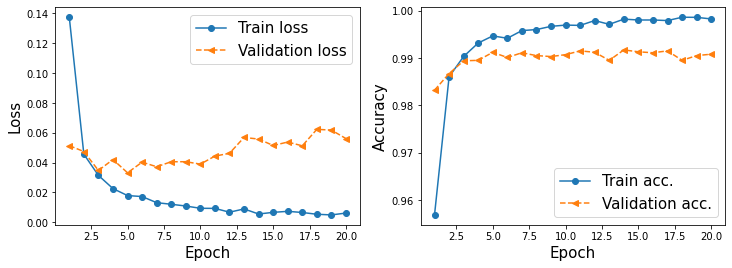

In [22]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [23]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    500/Unknown - 12s 23ms/step - loss: 0.0335 - accuracy: 0.9938
Test Acc. 99.38%


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


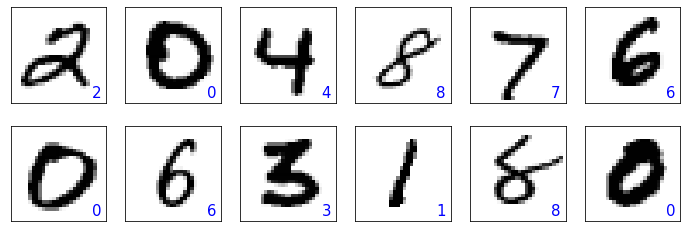

In [24]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()